In [131]:
from functions import parameters as param
from functions import download_data as down_data

import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions.utilities.preprocess import make_copy
from collections import Counter

In [132]:
proj_param = param.Proj_Param()

In [133]:
param_download_movie_lens_1m = {
    'proj_params' : proj_param,
    'data_key'  : 'movie_lens_1m',
}
df_users, df_movies, df_ratings = down_data.download_data(param_download_movie_lens_1m)

✅ MovieLens data loaded successfully.


In [134]:
df_ratings['rating'].value_counts()

rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

In [135]:
def explore_movie(df):
    df['genres'] = df['genres'].str.split('|')
    genre_freq = Counter(g for genre in df['genres'] for g in genre)
    df_genre = pd.DataFrame.from_dict(data=[genre_freq])
    df_genre = df_genre.T.reset_index()
    df_genre.columns = ['genre', 'count']
    sns.barplot(x= 'genre', y= 'count',data= df_genre.sort_values(by = 'count', ascending= False) , palette='viridis', hue='genre' )
    plt.xticks(rotation=90); # ; is to suppress the extra information about the tick labels
    # Least count genres can be considered as niche genres.
    return df

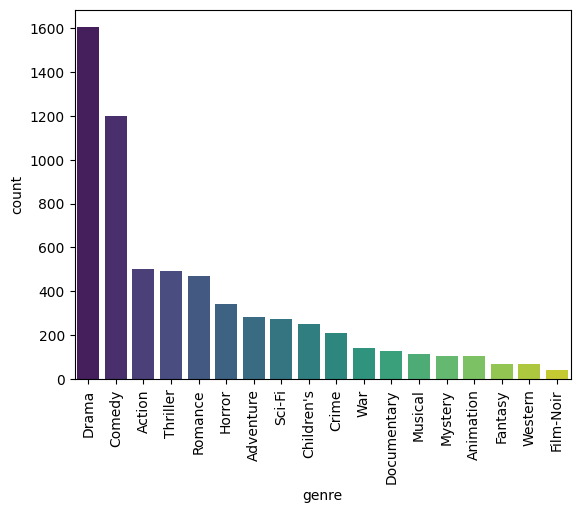

In [136]:
df_movies = explore_movie(df_movies)

In [137]:
# merge ratings and movie df_ to map movie title to movie 
def average_movie_rating(df_m,df_r):
    df_merged_movie_rating = pd.merge(df_m,df_r,how = 'left',left_on = 'movieId', right_on = 'movieId')
    first_cols = ['userId','title', 'rating','movieId']
    remaining_cols = [col for col in df_merged_movie_rating if col not in first_cols]
    df_movie_rating = df_merged_movie_rating[first_cols +remaining_cols]
    average_rating =df_movie_rating.groupby(by=['title'], dropna= False, as_index=False)['rating'].mean().rename(columns = {'rating' : 'avrg_rating'}).sort_values('avrg_rating', ascending=False)
    #df_average_rating = average_rating.rename(columns= { 'rating':'avrg_rating'})
    return (average_rating.fillna(average_rating['avrg_rating'].mean()))

average_rating = average_movie_rating(df_movies,df_ratings)
average_rating

,title,avrg_rating
3646,Ulysses (Ulisse) (1954),5.000000
2120,Lured (1947),5.000000
1250,Follow the Bitch (1998),5.000000
419,Bittersweet Motel (2000),5.000000
3235,Song of Freedom (1936),5.000000
...,...,...
3690,Vermin (1998),3.238892
3691,Vermont Is For Lovers (1992),3.238892
3729,War Stories (1995),3.238892
3834,"Woman in Question, The (1950)",3.238892


# Tranform genre to 1 and 0 (Multilabel encoding)

In [138]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
scaler_movie = MinMaxScaler()
mlb = MultiLabelBinarizer()

In [139]:
def preprocess_df_movies(df_m):
    # Encode genre column with 0 and 1
    df_m['genres']
    encoded_genre = mlb.fit_transform(df_m['genres'])
    df_encoded_genre = pd.DataFrame(encoded_genre,columns=mlb.classes_)
    # seperate year from movie name
    rls_year = df_m['title'].str.extract(r'\((\d{4})\)').rename(columns = {0 : 'year'})
    df_movies_processed = pd.concat([df_m,df_encoded_genre,rls_year],axis=1) # concatenate df_movies and year column
    df_movies_processed['year'] = scaler_movie.fit_transform(df_movies_processed[['year']])
    df_movies_processed.drop(['title', 'genres'], axis = 1, inplace= True)
    return df_movies_processed
df_movies_processed = preprocess_df_movies(df_movies)
df_movies_processed

,movieId,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.938272
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.938272
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.938272
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.938272
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.938272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
3879,3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000000
3880,3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000000
3881,3951,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000000


# Preprocess User Data

In [140]:
def preprocess_df_user(df_u):
    df_u.drop(['zip-code','occupation'],axis=1, inplace= True)  #remove irrelevant columns
    # Add fake nationality column to match client user features
    np.random.seed(42)
    df_u['nationality'] = np.random.choice(['USA', 'UK', 'Mexico', 'Canada'], size=len(df_users))
    norm = MinMaxScaler()
    df_u['age'] = norm.fit_transform(df_u[['age']])   # normalize age
    df_u = pd.get_dummies(data= df_u,
                        columns=['gender','nationality'],
                        dtype=int)
    return df_u
df_users = preprocess_df_user(df_users) 
df_users

,userId,age,gender_F,gender_M,nationality_Canada,nationality_Mexico,nationality_UK,nationality_USA
0,1,0.000000,1,0,0,1,0,0
1,2,1.000000,0,1,1,0,0,0
2,3,0.436364,0,1,0,0,0,1
3,4,0.800000,0,1,0,1,0,0
4,5,0.436364,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
6035,6036,0.436364,1,0,0,0,0,1
6036,6037,0.800000,1,0,0,0,1,0
6037,6038,1.000000,1,0,1,0,0,0
6038,6039,0.800000,1,0,0,1,0,0


# Infer User genre Preference from Ratings data

In [141]:
def select_ratings(df_r):
    df_r = df_r[df_r['rating']>=3]
    df_rating_user_movie = pd.merge(left= df_r, right= df_movies, left_on= 'movieId', right_on= 'movieId' , how= 'left')
    return df_rating_user_movie
df_rating_user_movie = select_ratings(df_ratings)

In [142]:
df_rating_user_movie

,userId,movieId,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),[Drama]
1,1,661,3,978302109,James and the Giant Peach (1996),"[Animation, Children's, Musical]"
2,1,914,3,978301968,My Fair Lady (1964),"[Musical, Romance]"
3,1,3408,4,978300275,Erin Brockovich (2000),[Drama]
4,1,2355,5,978824291,"Bug's Life, A (1998)","[Animation, Children's, Comedy]"
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986),"[Drama, War]"
836474,6040,1094,5,956704887,"Crying Game, The (1992)","[Drama, Romance, War]"
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995),"[Comedy, Drama]"
836476,6040,1096,4,956715648,Sophie's Choice (1982),[Drama]


In [143]:
user_genre_count = {}
for userId, group in df_rating_user_movie.groupby('userId'):
    user_genre_pref = []
    for g in group['genres']:
        user_genre_pref.extend(g)
    user_genre_count[userId] = dict(Counter(user_genre_pref).most_common(5))
    
#user_genre_count

In [144]:
df_user_genre = pd.DataFrame.from_dict(user_genre_count, orient= 'index')
df_user_genre#.notna().astype(int)

,Drama,Children's,Animation,Musical,Comedy,Action,Thriller,Romance,Adventure,Sci-Fi,Horror,Crime,Film-Noir,War,Mystery,Western,Fantasy,Documentary
1,21.0,20.0,18.0,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70.0,NaN,NaN,NaN,22.0,50.0,28.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,NaN,NaN,NaN,26.0,21.0,NaN,NaN,23.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,5.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,72.0,NaN,NaN,NaN,46.0,16.0,23.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,NaN,NaN,NaN,NaN,NaN,33.0,19.0,NaN,13.0,26.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5753,NaN,NaN,NaN,NaN,NaN,49.0,21.0,NaN,18.0,18.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5842,NaN,NaN,NaN,NaN,NaN,46.0,13.0,NaN,16.0,16.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
6007,NaN,NaN,NaN,NaN,NaN,129.0,72.0,NaN,63.0,60.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
df_user_genre = df_user_genre.notna().astype(int)
df_user_genre

,Drama,Children's,Animation,Musical,Comedy,Action,Thriller,Romance,Adventure,Sci-Fi,Horror,Crime,Film-Noir,War,Mystery,Western,Fantasy,Documentary
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0
5,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0
5753,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0
5842,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0
6007,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0


In [146]:
df_users

,userId,age,gender_F,gender_M,nationality_Canada,nationality_Mexico,nationality_UK,nationality_USA
0,1,0.000000,1,0,0,1,0,0
1,2,1.000000,0,1,1,0,0,0
2,3,0.436364,0,1,0,0,0,1
3,4,0.800000,0,1,0,1,0,0
4,5,0.436364,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
6035,6036,0.436364,1,0,0,0,0,1
6036,6037,0.800000,1,0,0,0,1,0
6037,6038,1.000000,1,0,1,0,0,0
6038,6039,0.800000,1,0,0,1,0,0


In [147]:
df_users.set_index('userId', inplace= True)
df_users

,age,gender_F,gender_M,nationality_Canada,nationality_Mexico,nationality_UK,nationality_USA
userId,,,,,,,
1,0.000000,1,0,0,1,0,0
2,1.000000,0,1,1,0,0,0
3,0.436364,0,1,0,0,0,1
4,0.800000,0,1,0,1,0,0
5,0.436364,0,1,0,1,0,0
...,...,...,...,...,...,...,...
6036,0.436364,1,0,0,0,0,1
6037,0.800000,1,0,0,0,1,0
6038,1.000000,1,0,1,0,0,0


In [148]:
df_user_rating_merged = df_users.join(df_user_genre, how='left' )
df_user_rating_merged.isna().any()


age                   False
gender_F              False
gender_M              False
nationality_Canada    False
nationality_Mexico    False
nationality_UK        False
nationality_USA       False
Drama                  True
Children's             True
Animation              True
Musical                True
Comedy                 True
Action                 True
Thriller               True
Romance                True
Adventure              True
Sci-Fi                 True
Horror                 True
Crime                  True
Film-Noir              True
War                    True
Mystery                True
Western                True
Fantasy                True
Documentary            True
dtype: bool

In [149]:
df_user_rating_merged = df_user_rating_merged.fillna(0)
df_user_rating_merged.isna().any()

age                   False
gender_F              False
gender_M              False
nationality_Canada    False
nationality_Mexico    False
nationality_UK        False
nationality_USA       False
Drama                 False
Children's            False
Animation             False
Musical               False
Comedy                False
Action                False
Thriller              False
Romance               False
Adventure             False
Sci-Fi                False
Horror                False
Crime                 False
Film-Noir             False
War                   False
Mystery               False
Western               False
Fantasy               False
Documentary           False
dtype: bool

# Make Clusters of similar users and similar movies

In [150]:

orig_user_Id = pd.Series(df_user_rating_merged.index, name='UserID')
print(orig_user_Id)

df_user_rating_merged.reset_index(drop= True,inplace=True)
df_user_rating_merged
#display(df_users)
#print(orig_user_Id)

0          1
1          2
2          3
3          4
4          5
        ... 
6035    6036
6036    6037
6037    6038
6038    6039
6039    6040
Name: UserID, Length: 6040, dtype: int64


,age,gender_F,gender_M,nationality_Canada,nationality_Mexico,nationality_UK,nationality_USA,Drama,Children's,Animation,...,Adventure,Sci-Fi,Horror,Crime,Film-Noir,War,Mystery,Western,Fantasy,Documentary
0,0.000000,1,0,0,1,0,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0,1,1,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.436364,0,1,0,0,0,1,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.800000,0,1,0,1,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.436364,0,1,0,1,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.436364,1,0,0,0,0,1,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6036,0.800000,1,0,0,0,1,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,1.000000,1,0,1,0,0,0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6038,0.800000,1,0,0,1,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [151]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=10, random_state=42)

In [152]:
df_user_rating_merged['cluster'] = kmeans_model.fit_predict(df_user_rating_merged)

In [153]:
df_user_rating_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 6040 non-null   float64
 1   gender_F            6040 non-null   int64  
 2   gender_M            6040 non-null   int64  
 3   nationality_Canada  6040 non-null   int64  
 4   nationality_Mexico  6040 non-null   int64  
 5   nationality_UK      6040 non-null   int64  
 6   nationality_USA     6040 non-null   int64  
 7   Drama               6040 non-null   float64
 8   Children's          6040 non-null   float64
 9   Animation           6040 non-null   float64
 10  Musical             6040 non-null   float64
 11  Comedy              6040 non-null   float64
 12  Action              6040 non-null   float64
 13  Thriller            6040 non-null   float64
 14  Romance             6040 non-null   float64
 15  Adventure           6040 non-null   float64
 16  Sci-Fi

# Find the best K

In [154]:
kmeans_inertia = []
k_range = range(2,100)
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(df_user_rating_merged)
    kmeans_inertia.append(kmeans_model.inertia_)

Text(0, 0.5, 'centroid change')

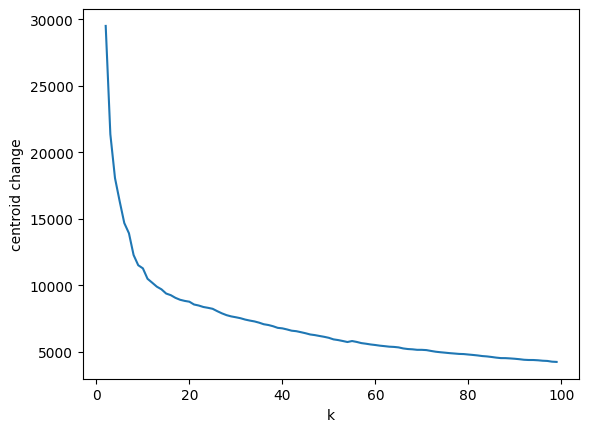

In [155]:
sns.lineplot(x=k_range, y  = kmeans_inertia)
plt.xlabel('k')
plt.ylabel('centroid change')

# Best K is between 10 - 20. So choosing 12 user groups

In [156]:
best_kmeans_user = KMeans(n_clusters=12)
df_user_rating_merged['cluster'] = best_kmeans_user.fit_predict(df_user_rating_merged)
df_user_rating_merged

,age,gender_F,gender_M,nationality_Canada,nationality_Mexico,nationality_UK,nationality_USA,Drama,Children's,Animation,...,Sci-Fi,Horror,Crime,Film-Noir,War,Mystery,Western,Fantasy,Documentary,cluster
0,0.000000,1,0,0,1,0,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1.000000,0,1,1,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.436364,0,1,0,0,0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
3,0.800000,0,1,0,1,0,0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,0.436364,0,1,0,1,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.436364,1,0,0,0,0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
6036,0.800000,1,0,0,0,1,0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
6037,1.000000,1,0,1,0,0,0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6
6038,0.800000,1,0,0,1,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


In [157]:
df_genre

,genre,count
0,Animation,105
1,Children's,251
2,Comedy,1200
3,Adventure,283
4,Fantasy,68
5,Romance,471
6,Drama,1603
7,Action,503
8,Crime,211
9,Thriller,492


# 5 Popular movies in each cluster
# When a new user is assigned to a cluster recommend from these popular movies

In [158]:

pop_genre_cluster = {}
for cluster,group in df_user_rating_merged.groupby('cluster'):
    #print(group.count())
    cluster_genre = {}
    for col in df_genre['genre']:
        cluster_genre[col] = int(group[col].values.sum())
    top_5_genre =   sorted(cluster_genre.items(), key = lambda x : x[1], reverse= True)[:5]
    print(top_5_genre)
    pop_genre_cluster[cluster] = [g for g,cnt in top_5_genre]
    
pop_genre_cluster

[('Action', 465), ('Drama', 399), ('Comedy', 394), ('Adventure', 355), ('Thriller', 292)]
[('Sci-Fi', 803), ('Thriller', 779), ('Drama', 777), ('Action', 773), ('Comedy', 568)]
[('Action', 581), ('Thriller', 534), ('Drama', 516), ('Sci-Fi', 437), ('Comedy', 435)]
[('Drama', 1142), ('Comedy', 1113), ('Romance', 963), ('Action', 865), ('Thriller', 796)]
[('Drama', 599), ('Comedy', 568), ('Thriller', 467), ('Romance', 451), ('Action', 424)]
[('Crime', 370), ('Drama', 367), ('Thriller', 361), ('Comedy', 316), ('Action', 295)]
[('Comedy', 407), ("Children's", 360), ('Drama', 340), ('Romance', 280), ('Animation', 168)]
[('Drama', 508), ('Comedy', 496), ('Action', 404), ('Thriller', 358), ('Romance', 353)]
[('Action', 220), ('Adventure', 218), ('Sci-Fi', 214), ('Comedy', 158), ('Thriller', 151)]
[('Adventure', 269), ('Sci-Fi', 269), ('Action', 260), ('Drama', 256), ('Comedy', 250)]
[('Drama', 293), ('Comedy', 272), ('Thriller', 231), ('Romance', 222), ('Action', 218)]
[('Drama', 265), ('Comed

{0: ['Action', 'Drama', 'Comedy', 'Adventure', 'Thriller'],
 1: ['Sci-Fi', 'Thriller', 'Drama', 'Action', 'Comedy'],
 2: ['Action', 'Thriller', 'Drama', 'Sci-Fi', 'Comedy'],
 3: ['Drama', 'Comedy', 'Romance', 'Action', 'Thriller'],
 4: ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action'],
 5: ['Crime', 'Drama', 'Thriller', 'Comedy', 'Action'],
 6: ['Comedy', "Children's", 'Drama', 'Romance', 'Animation'],
 7: ['Drama', 'Comedy', 'Action', 'Thriller', 'Romance'],
 8: ['Action', 'Adventure', 'Sci-Fi', 'Comedy', 'Thriller'],
 9: ['Adventure', 'Sci-Fi', 'Action', 'Drama', 'Comedy'],
 10: ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action'],
 11: ['Drama', 'Comedy', 'Romance', 'Thriller', 'Action']}